In [1]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from mpl_toolkits.basemap import Basemap

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_MesoWest.MesoWest_nearesttime import get_mesowest_nearesttime
from BB_MesoWest.MesoWest_percentiles import get_mesowest_percentiles
from BB_data.grid_manager import pluck_point_new
from BB_wx_calcs.wind import wind_uv_to_spd

In [17]:
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b')

import matplotlib as mpl 
two_column = 5.5
one_column = 3.2
twothird_column = 6.8
mpl.rcParams['figure.figsize'] = [6.5, 8.5]
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.03
mpl.rcParams['figure.subplot.hspace'] = 0.00
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
    
mpl.rcParams['savefig.dpi'] = 600    # 600 for print

| One Colulmn | 2/3 Page   | Two Columns   | More than 2 columns  |
|---|---|---|---|
| 3.2   | 4.5  | 5.5  | 6.5  |

In [3]:
# Load Lat/Lon Grid
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/'
latlon_file = h5py.File(DIR+'OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

-----

# Percentile thresholds for given month and hour
Answers the question: At what percentile does the wind first exceed a threshold?  
- Darker colors = the wind threshold is more rare, becuase it is requires a 90th or 95th percentile to get that strong.  
- Lighter colors = the wind threshold is more common, becuase it only happens more than 10


In [4]:
def get_area(FILE, STAT):
    """
    Return the values from an area in the HDF5 file array
    """
    with h5py.File(FILE, 'r') as f:
        return f[STAT][:]

In [15]:
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
m = draw_CONUS_HRRR_map(res='f', area_thresh=1000000)

M = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'October', 'Nov', 'Dec']

# Wind Speed Percentiles

In [7]:
# Percentile Variable and Statistic of interest
var = 'UVGRD:10 m'
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

month = 10
hour = 6

FILE = DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % (variable, month, 15, hour)
  
threshold = 5

percentiles = [0,1,2,3,4,5,10,25,33,50,66,75,90,95,96,97,98,99,100]

# Make sure the percentiles are sorted and they are in desending order...
percentiles.sort()
percentiles.reverse()

# Initiate an array of 100 for maximum percentile, becuase every point
# will require at least the maximum percentile to reach the threshold.
# We will replace grids with other percentiles if one is found to 
# hit the threshold at an earlier percentile.
pdata = np.ones_like(lon)*100

for P in percentiles:
    # Temporaritlye store the percentile field
    ptemp = get_area(FILE, 'p%02d' % P)
    pdata[ptemp >= threshold] = P

# Need to sort percentiles back to ascending order
percentiles.sort()

# Draw the map

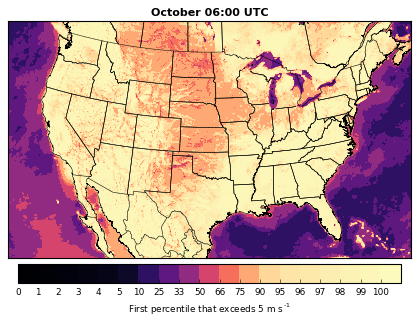

In [20]:
m.drawcoastlines(linewidth=.5); m.drawstates(linewidth=.5); m.drawcountries(linewidth=.5)
m.contourf(lon, lat, pdata, 
           levels=percentiles+[101],
           latlon=True,
           cmap='magma')
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95, ticks=percentiles)
cb.set_label(r'First percentile that exceeds %s m s$\mathregular{^{-1}}$' % threshold)

plt.title('%s %02d:00 UTC' % (M[month-1], hour), fontweight='semibold')

plt.savefig('./figs/CONUS_percentiles_thresh_m%02d_h%02d' % (month, hour))